In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
#creating dataset

df = pd.read_csv("file.csv")
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,23.7000,26.272,585.200000,749.200000,0.004764,1
1,23.7180,26.290,578.400000,760.400000,0.004773,1
2,23.7300,26.230,572.666667,769.666667,0.004765,1
3,23.7225,26.125,493.750000,774.750000,0.004744,1
4,23.7540,26.200,488.600000,779.000000,0.004767,1


In [3]:
dataset = df.to_numpy()
print('dataset.shape:', dataset.shape)

dataset.shape: (2665, 6)


In [4]:
#Number of timesteps used for predicting the future time-steps
N_days = 5

#Number of future time-steps
N_out = 4

#Number of features
N_features = 5

In [5]:
ds_n = np.zeros((len(dataset) - (N_days + N_out) + 1, N_days*N_features+N_out))

In [6]:
for i in range(len(dataset) - (N_days + N_out) + 1):
    for j in range(N_days):
        ds_n[i, N_features*j:N_features*(j+1)] = dataset[i+j, 0 : 5]

    ds_n[i, N_days*N_features] = dataset[i+N_days, 4]
    ds_n[i, N_days*N_features+1] = dataset[i+N_days+1, 4]
    ds_n[i, N_days*N_features+2] = dataset[i+N_days+2, 4]
    
    ds_n[i, N_days*N_features+3] = dataset[i+N_days+3, 4]

In [7]:
ds_n.shape

(2657, 29)

In [8]:
ds_train, ds_test = train_test_split(ds_n, test_size=0.3)
print('ds_train.shape, ds_test.shape:', ds_train.shape, ds_test.shape)

ds_train.shape, ds_test.shape: (1859, 29) (798, 29)


In [9]:
np.savetxt("train_data_RNN.csv", ds_train, delimiter=",")
np.savetxt("test_data_RNN.csv", ds_test, delimiter=",")

In [10]:
ds_test = pd.read_csv("test_data_RNN.csv")

In [11]:
ds_test.head(5)

,2.047800000000000153e+01,2.237000000000000099e+01,0.000000000000000000e+00,4.356000000000000227e+02,3.325549045892899850e-03,2.045599999999999952e+01,2.235000000000000142e+01,0.000000000000000000e+00.1,4.330000000000000000e+02,3.318027352347600184e-03,...,3.333084430714899991e-03,2.042666666666669428e+01,2.232333333333330572e+01,0.000000000000000000e+00.4,4.360000000000000000e+02,3.308019689135399937e-03,3.333084430714899991e-03.1,3.328837093719499898e-03.1,3.308019689135399937e-03.1,3.316436378515800164e-03
0,22.68,30.870000,433.000000,1316.666667,0.005267,22.700,30.890000,433.000000,1306.333333,0.005277,...,0.005241,22.675,30.745000,424.6,1298.200000,0.005244,0.005256,0.005241,0.005245,0.005220
1,23.00,30.000000,464.000000,1261.000000,0.005219,23.000,30.016667,462.333333,1263.666667,0.005222,...,0.005232,23.000,30.120000,461.0,1280.200000,0.005240,0.005245,0.005259,0.005270,0.005262
2,22.16,27.956000,556.400000,1173.800000,0.004617,22.200,27.917500,555.000000,1170.750000,0.004622,...,0.004599,22.200,27.823333,555.0,1160.833333,0.004606,0.004601,0.004601,0.004598,0.004589
3,20.29,22.856667,413.666667,442.666667,0.003359,20.290,22.956000,433.000000,445.600000,0.003374,...,0.003400,20.290,23.200000,419.0,470.400000,0.003410,0.003414,0.003414,0.003418,0.003431
4,20.29,22.700000,0.000000,432.250000,0.003336,20.272,22.680000,0.000000,437.000000,0.003329,...,0.003336,20.290,22.700000,0.0,436.000000,0.003336,0.003336,0.003336,0.003336,0.003336


In [12]:
#loading training data
ds_train = pd.read_csv("train_data_RNN.csv", header=None).to_numpy()
X_train, y_train = ds_train[:, :-4], ds_train[:, -4:]
X_train = X_train.reshape((len(X_train), N_days, N_features))

In [13]:
X_train.shape

(1859, 5, 5)

In [14]:
normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
normalizer.adapt(X_train)

In [15]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min')

In [16]:
def runModel(model):
    model.summary()
    model.compile(loss='mse', optimizer='Adam', metrics=['mse','mae'])
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.15, callbacks=[earlyStopping])
    return history

In [17]:
X_train.shape[1:]

(5, 5)

# RNN

In [40]:
# 1 Layer RNN
inputs = tf.keras.Input(shape=X_train.shape[1:])
x = normalizer(inputs)

x = SimpleRNN(32, return_sequences=False)(x)
output = Dense(1 * N_out, activation='linear')(x)


model_1 = tf.keras.Model(inputs, output)
history = runModel(model_1)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 5, 5)]            0         
_________________________________________________________________
normalization (Normalization (None, 5, 5)              11        
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 32)                1216      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 132       
Total params: 1,359
Trainable params: 1,348
Non-trainable params: 11
_________________________________________________________________
Train on 1580 samples, validate on 279 samples
Epoch 1/100
1580/1580 [==============================] - 3s 2ms/sample - loss: 0.1156 - mse: 0.1156 - mae: 0.2159 - val_loss: 0.0089 - val_mse: 0.0089 - val_mae: 0.0647
Epoch 2/100
1580/1580 [===============

1580/1580 [==============================] - 0s 190us/sample - loss: 1.1962e-04 - mse: 1.1962e-04 - mae: 0.0074 - val_loss: 1.5214e-04 - val_mse: 1.5214e-04 - val_mae: 0.0067
Epoch 41/100
1580/1580 [==============================] - 0s 211us/sample - loss: 1.0933e-04 - mse: 1.0933e-04 - mae: 0.0069 - val_loss: 1.4841e-04 - val_mse: 1.4841e-04 - val_mae: 0.0066
Epoch 42/100
1580/1580 [==============================] - 0s 190us/sample - loss: 1.0817e-04 - mse: 1.0817e-04 - mae: 0.0070 - val_loss: 1.4874e-04 - val_mse: 1.4874e-04 - val_mae: 0.0065
Epoch 43/100
1580/1580 [==============================] - 0s 190us/sample - loss: 1.0601e-04 - mse: 1.0601e-04 - mae: 0.0070 - val_loss: 1.4922e-04 - val_mse: 1.4922e-04 - val_mae: 0.0066
Epoch 44/100
1580/1580 [==============================] - 0s 179us/sample - loss: 9.7762e-05 - mse: 9.7762e-05 - mae: 0.0066 - val_loss: 1.4314e-04 - val_mse: 1.4314e-04 - val_mae: 0.0066
Epoch 45/100
1580/1580 [==============================] - 0s 148us/sample

Epoch 84/100
1580/1580 [==============================] - 0s 125us/sample - loss: 3.5954e-05 - mse: 3.5954e-05 - mae: 0.0043 - val_loss: 8.6624e-05 - val_mse: 8.6624e-05 - val_mae: 0.0051
Epoch 85/100
1580/1580 [==============================] - 0s 130us/sample - loss: 3.8381e-05 - mse: 3.8381e-05 - mae: 0.0044 - val_loss: 8.1856e-05 - val_mse: 8.1856e-05 - val_mae: 0.0047
Epoch 86/100
1580/1580 [==============================] - 0s 137us/sample - loss: 3.4495e-05 - mse: 3.4495e-05 - mae: 0.0041 - val_loss: 7.7151e-05 - val_mse: 7.7151e-05 - val_mae: 0.0044
Epoch 87/100
1580/1580 [==============================] - 0s 137us/sample - loss: 3.4614e-05 - mse: 3.4614e-05 - mae: 0.0042 - val_loss: 7.0436e-05 - val_mse: 7.0436e-05 - val_mae: 0.0040
Epoch 88/100
1580/1580 [==============================] - 0s 138us/sample - loss: 3.2335e-05 - mse: 3.2335e-05 - mae: 0.0040 - val_loss: 8.0746e-05 - val_mse: 8.0746e-05 - val_mae: 0.0052
Epoch 89/100
1580/1580 [==============================] - 0s

In [19]:
print(history.history.keys())

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


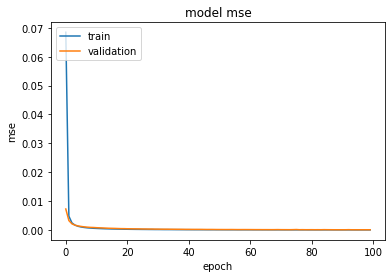

In [20]:
# summarize history for mse
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
X_train.shape[1:]

(5, 5)

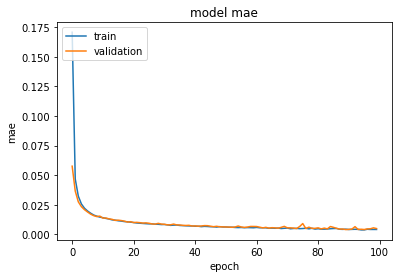

In [22]:
# summarize history for mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [36]:
#Loading the testing data
ds_test = pd.read_csv("test_data_RNN.csv", header=None).to_numpy()
X_test, y_test = ds_test[:, :-4], ds_test[:, -4:]
X_test = X_test.reshape((len(X_test), N_days, N_features))

X_test2, y_test2 = ds_test[:, :-4], ds_test[:, -4:]
X_test2 = X_test2.reshape((len(X_test), N_days, N_features))

In [24]:
X_test.shape

(798, 5, 5)

In [25]:
#Runing prediction on the test data and output required plot and loss
scores = model_1.evaluate(X_test, y_test)

798/798 [==============================] - 0s 59us/sample - loss: 1.5100e-04 - mse: 1.5100e-04 - mae: 0.0048


In [26]:
X_test.shape

(798, 5, 5)

In [41]:
y_pred = model_1.predict(X_test)

In [28]:
y_pred.shape

(798, 4)

In [29]:
y_pred

array([[-0.00313817,  0.0045525 , -0.00613165,  0.00020793],
       [ 0.00998316,  0.00551302,  0.00418508,  0.00190249],
       [ 0.01120083,  0.00591315,  0.00446421,  0.00453619],
       ...,
       [ 0.00202231,  0.01782556,  0.01399483, -0.00494091],
       [-0.00351687,  0.00452317, -0.00300962,  0.00076962],
       [ 0.00265826,  0.00165771, -0.00320983,  0.0037636 ]],
      dtype=float32)

In [30]:
y_test

array([[0.00333308, 0.00332884, 0.00330802, 0.00331644],
       [0.00525628, 0.0052405 , 0.00524465, 0.00522004],
       [0.00524519, 0.00525923, 0.00526975, 0.00526215],
       ...,
       [0.00407494, 0.00407922, 0.00406865, 0.00407922],
       [0.00331697, 0.00332521, 0.00332006, 0.00331652],
       [0.00362275, 0.00361145, 0.0036365 , 0.00361145]])

In [ ]:
out1, out2 = model.predict(pred_X)

# LSTM

In [46]:
# 1-Layer LSTM
inputs = tf.keras.Input(shape=X_train.shape[1:])
x = normalizer(inputs)

x = LSTM(64, return_sequences=False)(x)

output = Dense(1 * N_out, activation='linear')(x)

model_2 = tf.keras.Model(inputs, output)
history = runModel(model_2)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 5, 5)]            0         
_________________________________________________________________
normalization (Normalization (None, 5, 5)              11        
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 260       
Total params: 18,191
Trainable params: 18,180
Non-trainable params: 11
_________________________________________________________________
Train on 1580 samples, validate on 279 samples
Epoch 1/100
1580/1580 [==============================] - 3s 2ms/sample - loss: 0.0016 - mse: 0.0016 - mae: 0.0222 - val_loss: 7.5723e-05 - val_mse: 7.5723e-05 - val_mae: 0.0056
Epoch 2/100
1580/1580 [=====

1580/1580 [==============================] - 0s 137us/sample - loss: 1.2211e-06 - mse: 1.2211e-06 - mae: 8.2304e-04 - val_loss: 1.0669e-06 - val_mse: 1.0669e-06 - val_mae: 6.7849e-04
Epoch 40/100
1580/1580 [==============================] - 0s 148us/sample - loss: 1.0436e-06 - mse: 1.0436e-06 - mae: 7.5393e-04 - val_loss: 1.2998e-06 - val_mse: 1.2998e-06 - val_mae: 7.9053e-04
Epoch 41/100
1580/1580 [==============================] - 0s 147us/sample - loss: 1.0922e-06 - mse: 1.0922e-06 - mae: 7.6840e-04 - val_loss: 1.6243e-06 - val_mse: 1.6243e-06 - val_mae: 9.0443e-04
Epoch 42/100
1580/1580 [==============================] - 0s 164us/sample - loss: 1.0049e-06 - mse: 1.0049e-06 - mae: 7.5261e-04 - val_loss: 1.0616e-06 - val_mse: 1.0616e-06 - val_mae: 6.9231e-04
Epoch 43/100
1580/1580 [==============================] - 0s 142us/sample - loss: 9.3617e-07 - mse: 9.3617e-07 - mae: 7.2514e-04 - val_loss: 8.0433e-07 - val_mse: 8.0433e-07 - val_mae: 5.8989e-04
Epoch 44/100
1580/1580 [=========

1580/1580 [==============================] - 0s 159us/sample - loss: 3.4011e-06 - mse: 3.4011e-06 - mae: 0.0013 - val_loss: 5.5761e-06 - val_mse: 5.5761e-06 - val_mae: 0.0018
Epoch 82/100
1580/1580 [==============================] - 0s 179us/sample - loss: 6.9773e-06 - mse: 6.9773e-06 - mae: 0.0017 - val_loss: 1.9644e-06 - val_mse: 1.9644e-06 - val_mae: 0.0011
Epoch 83/100
1580/1580 [==============================] - 0s 162us/sample - loss: 2.8788e-06 - mse: 2.8788e-06 - mae: 0.0012 - val_loss: 3.2590e-06 - val_mse: 3.2590e-06 - val_mae: 0.0014
Epoch 84/100
1580/1580 [==============================] - 0s 149us/sample - loss: 4.8346e-06 - mse: 4.8346e-06 - mae: 0.0016 - val_loss: 3.5522e-06 - val_mse: 3.5522e-06 - val_mae: 0.0013
Epoch 85/100
1580/1580 [==============================] - 0s 154us/sample - loss: 3.7549e-06 - mse: 3.7549e-06 - mae: 0.0014 - val_loss: 3.1081e-06 - val_mse: 3.1081e-06 - val_mae: 0.0013
Epoch 86/100
1580/1580 [==============================] - 0s 144us/sample

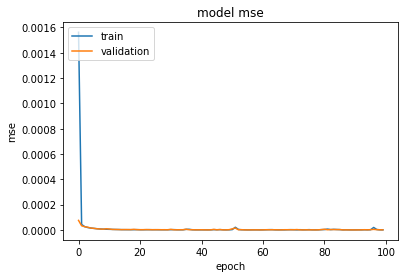

In [47]:
# summarize history for mse
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

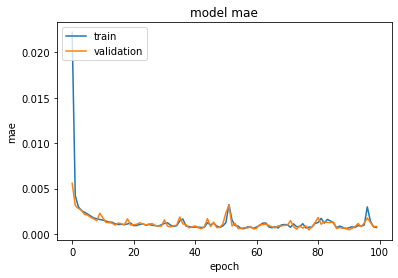

In [48]:
# summarize history for mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [49]:
#Runing prediction on the test data and output required plot and loss
scores_2 = model_2.evaluate(X_test, y_test)

798/798 [==============================] - 0s 65us/sample - loss: 1.1643e-06 - mse: 1.1643e-06 - mae: 8.5998e-04


In [50]:
y_pred_2 = model_2.predict(X_test)

In [51]:
y_pred_2

array([[0.00340869, 0.00187094, 0.00453314, 0.00166988],
       [0.00419653, 0.00523957, 0.00702706, 0.0023886 ],
       [0.00357645, 0.00542513, 0.00672065, 0.00286548],
       ...,
       [0.00448753, 0.00394611, 0.00542675, 0.00337865],
       [0.00313072, 0.00180351, 0.00454994, 0.00185209],
       [0.00302768, 0.00278508, 0.00571694, 0.00324888]], dtype=float32)

# Bi Directional LSTM

In [52]:
#Bidrectional LSTM
inputs = tf.keras.Input(shape=X_train.shape[1:])
x = normalizer(inputs)

x = Bidirectional(LSTM(32, return_sequences=False))(x)

output = Dense(1 * N_out, activation='linear')(x)

model_3 = tf.keras.Model(inputs, output)
history = runModel(model_3)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 5, 5)]            0         
_________________________________________________________________
normalization (Normalization (None, 5, 5)              11        
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                9728      
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 260       
Total params: 9,999
Trainable params: 9,988
Non-trainable params: 11
_________________________________________________________________
Train on 1580 samples, validate on 279 samples
Epoch 1/100
1580/1580 [==============================] - 7s 5ms/sample - loss: 0.0076 - mse: 0.0076 - mae: 0.0502 - val_loss: 1.8287e-04 - val_mse: 1.8287e-04 - val_mae: 0.0094
Epoch 2/100
1580/1580 [=======

Epoch 40/100
1580/1580 [==============================] - 0s 228us/sample - loss: 3.3524e-06 - mse: 3.3524e-06 - mae: 0.0013 - val_loss: 3.6201e-06 - val_mse: 3.6201e-06 - val_mae: 0.0014
Epoch 41/100
1580/1580 [==============================] - 0s 201us/sample - loss: 2.7138e-06 - mse: 2.7138e-06 - mae: 0.0012 - val_loss: 2.6591e-06 - val_mse: 2.6591e-06 - val_mae: 0.0012
Epoch 42/100
1580/1580 [==============================] - 0s 206us/sample - loss: 3.1264e-06 - mse: 3.1264e-06 - mae: 0.0013 - val_loss: 3.6268e-06 - val_mse: 3.6268e-06 - val_mae: 0.0015
Epoch 43/100
1580/1580 [==============================] - 0s 225us/sample - loss: 3.3931e-06 - mse: 3.3931e-06 - mae: 0.0014 - val_loss: 2.2199e-06 - val_mse: 2.2199e-06 - val_mae: 0.0011
Epoch 44/100
1580/1580 [==============================] - 0s 301us/sample - loss: 2.7251e-06 - mse: 2.7251e-06 - mae: 0.0012 - val_loss: 3.4752e-06 - val_mse: 3.4752e-06 - val_mae: 0.0014
Epoch 45/100
1580/1580 [==============================] - 1s

1580/1580 [==============================] - 1s 352us/sample - loss: 2.2118e-06 - mse: 2.2118e-06 - mae: 0.0011 - val_loss: 2.8354e-06 - val_mse: 2.8354e-06 - val_mae: 0.0012
Epoch 84/100
1580/1580 [==============================] - 0s 283us/sample - loss: 2.7820e-06 - mse: 2.7820e-06 - mae: 0.0013 - val_loss: 4.5546e-06 - val_mse: 4.5546e-06 - val_mae: 0.0017
Epoch 85/100
1580/1580 [==============================] - 0s 249us/sample - loss: 4.2641e-06 - mse: 4.2641e-06 - mae: 0.0015 - val_loss: 1.5313e-06 - val_mse: 1.5313e-06 - val_mae: 9.0159e-04
Epoch 86/100
1580/1580 [==============================] - 0s 252us/sample - loss: 1.9905e-06 - mse: 1.9905e-06 - mae: 0.0011 - val_loss: 1.8919e-06 - val_mse: 1.8919e-06 - val_mae: 0.0011
Epoch 87/100
1580/1580 [==============================] - 0s 221us/sample - loss: 1.7212e-06 - mse: 1.7212e-06 - mae: 0.0010 - val_loss: 1.6006e-06 - val_mse: 1.6006e-06 - val_mae: 9.4874e-04
Epoch 88/100
1580/1580 [==============================] - 0s 254u

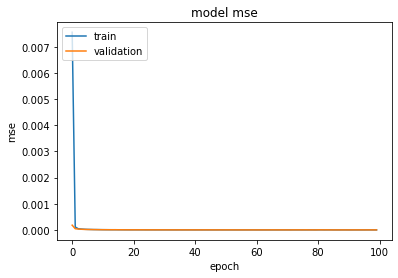

In [53]:
# summarize history for mse
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

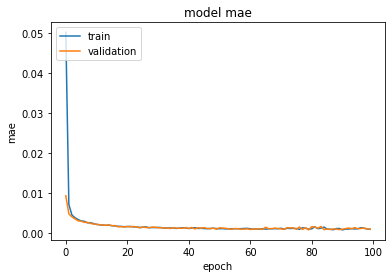

In [54]:
# summarize history for mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [55]:
#Runing prediction on the test data and output required plot and loss
scores_3 = model_3.evaluate(X_test, y_test)

798/798 [==============================] - 0s 78us/sample - loss: 1.9801e-06 - mse: 1.9801e-06 - mae: 0.0011


In [56]:
y_pred_3 = model_3.predict(X_test)

In [57]:
y_pred_3

array([[0.00421349, 0.00094409, 0.00478885, 0.00282801],
       [0.00490869, 0.0087274 , 0.00433164, 0.00677028],
       [0.00593534, 0.00762753, 0.00580225, 0.00627758],
       ...,
       [0.00446436, 0.0048858 , 0.00291754, 0.0041301 ],
       [0.00364093, 0.00100135, 0.00496948, 0.00269552],
       [0.00244528, 0.00147127, 0.00550827, 0.0019547 ]], dtype=float32)